# Практическая работа №2

## Анализ логов

Студент: Картунчиков Артем Максимович ББМО-01-23

## Клонирование рабочего репозитория

In [ ]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 563 (delta 59), reused 59 (delta 50), pack-reused 473
Receiving objects: 100% (563/563), 7.32 MiB | 10.54 MiB/s, done.
Resolving deltas: 100% (259/259), done.


# Задание регулярного выражения

Пример лога который необходимо распарсить:
```
nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.008 25746 INFO nova.osapi_compute.wsgi.server [req-38101a0b-2096-447d-96ea-a692162415ae 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2477829
```
Поля лога:
- nova-api.log.1.2017-05-16_13:53:08 - Logrecord
- 2017-05-16 - Date
- 00:00:00.008 - Time
- 25746 - Pid
- INFO - Level
- nova.osapi_compute.wsgi.server - Component
- req-38101a0b-2096-447d-96ea-a692162415ae 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - - - ADDR
- 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2477829 - Content

Поля были выбраны в соответствии с полями обозначенными в файле OpenStack_2k.log_structured.csv

In [ ]:
import re

pattern = re.compile(r'(.*?)\s(\d\d\d\d-\d\d-\d\d)\s(\d\d:\d\d:\d\d\.\d\d\d)\s(\d{0,})\s(\w{0,})\s(.*?)\s\[(.*?)\]\s(.*)')


# Создание базы данных

In [ ]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

import sqlite3

db_path = './db/log-analysis.db'

connection = sqlite3.connect(db_path)

cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS LogTable")

cursor.execute("CREATE TABLE LogTable (id INTEGER PRIMARY KEY AUTOINCREMENT,\
                logrecord VARCHAR(255), date DATE, time TIME, pid INT, level VARCHAR(50),\
                component VARCHAR(255), addr VARCHAR(255), content TEXT)")

connection.commit()

cursor.close()

connection.close()

# Парсинг лога в бд

In [ ]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DELETE FROM LogTable")

with open('./loghub/OpenStack/OpenStack_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = pattern.match(line)
        if log_match:
            logrecord = log_match.group(1)
            date = log_match.group(2)
            time = log_match.group(3)
            pid = log_match.group(4)
            level = log_match.group(5)
            component = log_match.group(6)
            addr = log_match.group(7)
            content = log_match.group(8)
            values = (logrecord, date, time, pid, level, component, addr, content)
            sql = "INSERT INTO LogTable (logrecord, date, time, pid, level, component, addr, content) VALUES (?, ?, ?, ?, ?, ?, ?, ?)"
            cursor.execute(sql, values)

connection.commit()
cursor.close()
connection.close()

# Просмотр БД

In [ ]:
import pandas as pd

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("SELECT * FROM LogTable")
rows = cursor.fetchall()

cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=("id", "logrecord","date", "time", "pid", "level", "component", "addr", "content"))
log_df

,id,logrecord,date,time,pid,level,component,addr,content
0,1,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:00.008,25746,INFO,nova.osapi_compute.wsgi.server,req-38101a0b-2096-447d-96ea-a692162415ae 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4..."
1,2,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:00.272,25746,INFO,nova.osapi_compute.wsgi.server,req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4..."
2,3,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:01.551,25746,INFO,nova.osapi_compute.wsgi.server,req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4..."
3,4,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:01.813,25746,INFO,nova.osapi_compute.wsgi.server,req-2a3dc421-6604-42a7-9390-a18dc824d5d6 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4..."
4,5,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:03.091,25746,INFO,nova.osapi_compute.wsgi.server,req-939eb332-c1c1-4e67-99b8-8695f8f1980a 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4..."
...,...,...,...,...,...,...,...,...,...
1995,1996,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:14:47.410,25746,INFO,nova.osapi_compute.wsgi.server,req-699eeadf-6db8-44a4-8521-1ab4e8a53b53 113d3...,"10.11.10.1 ""DELETE /v2/54fadb412c4e40cdbaed933..."
1996,1997,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:14:47.447,2931,INFO,nova.compute.manager,req-699eeadf-6db8-44a4-8521-1ab4e8a53b53 113d3...,[instance: faf974ea-cba5-4e1b-93f4-3a3bc606006...
1997,1998,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:14:47.652,25799,INFO,nova.metadata.wsgi.server,req-e5e061d6-f2aa-464b-9512-2fd6c7c9a812 - - -...,"10.11.21.143,10.11.10.1 ""GET /latest/meta-data..."
1998,1999,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16,00:14:47.663,2931,INFO,nova.virt.libvirt.driver,-,[instance: faf974ea-cba5-4e1b-93f4-3a3bc606006...


# Распределение используемых компонентов

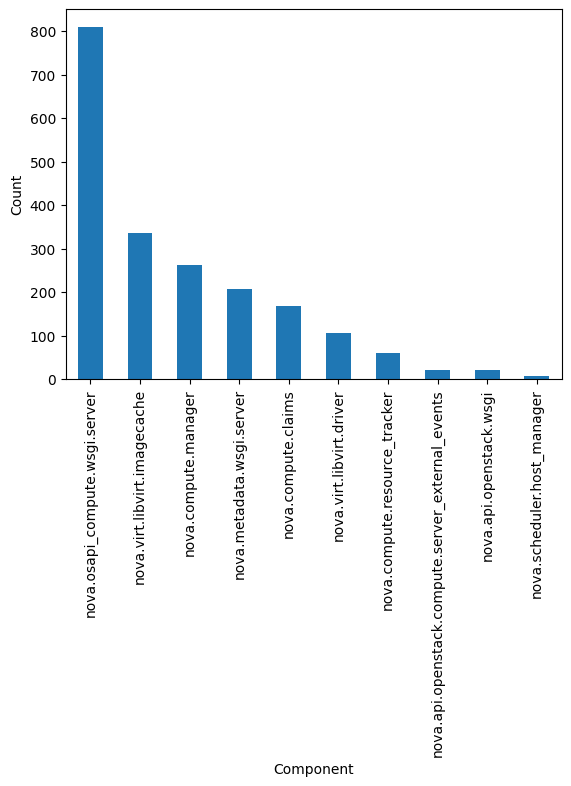

In [ ]:
import matplotlib.pyplot as plt

components_distrib = log_df['component'].value_counts()

components_distrib.plot(kind='bar')

plt.xlabel('Component')
plt.ylabel('Count')
plt.show()

# Распределение уровней логирования

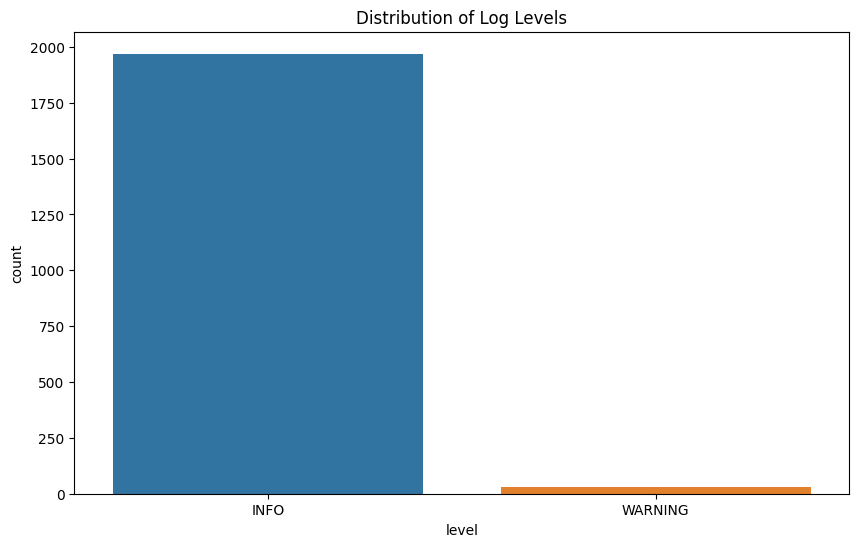

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='level', data=log_df)
plt.title('Distribution of Log Levels')
plt.show()


# Колличество событий по времени

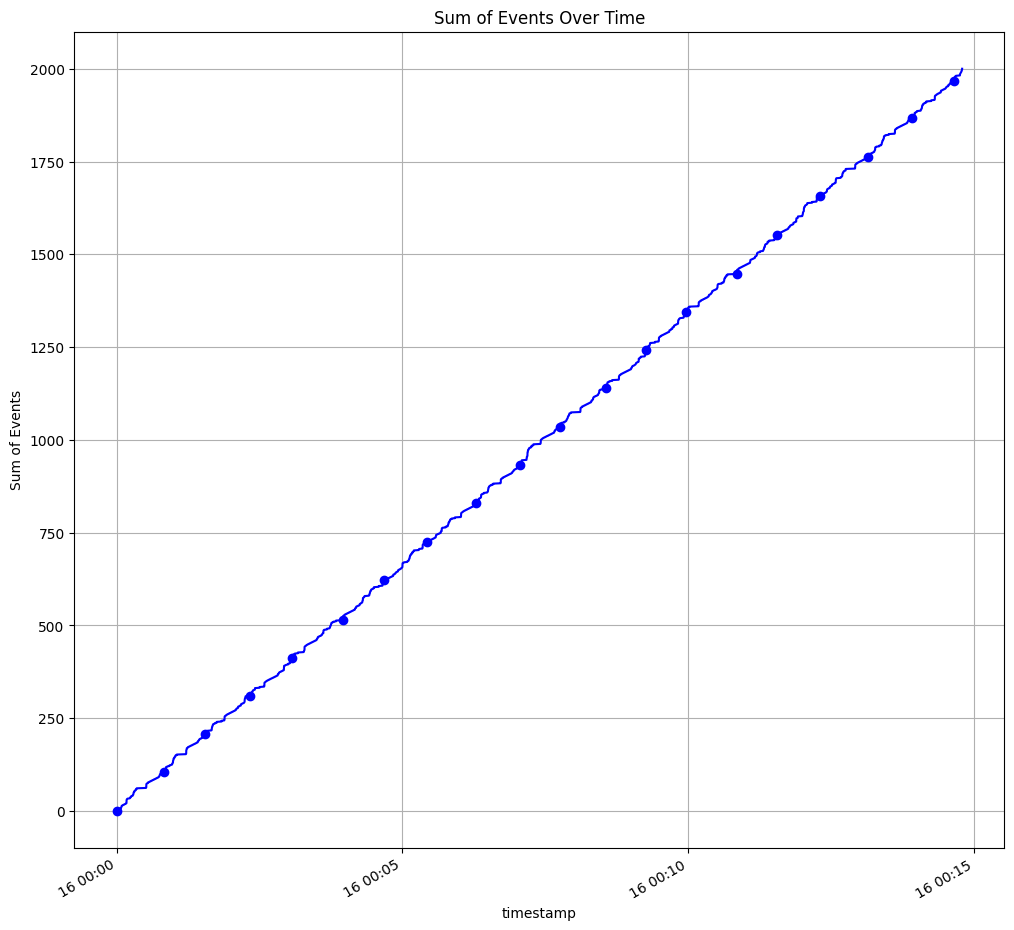

In [ ]:
log_df['timestamp'] = pd.to_datetime(log_df['date'].astype(str) + ' ' + log_df['time'].astype(str))

log_df = log_df.dropna(subset=['timestamp'])

events_per_time = log_df.groupby('timestamp').size().cumsum()

plt.figure(figsize=(12, 12))
events_per_time.plot(marker='o', linestyle='-', color='b', markevery=100)
plt.title('Sum of Events Over Time')
plt.xlabel('timestamp')
plt.ylabel('Sum of Events')
plt.grid(True)
plt.show()
